> # Installing Dependancies and importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
!pip install tensorflow
# To install Keras
!pip install -q tensorflow keras keras-cv
!pip install -U matplotlib==3.8.4 seaborn==0.13.2
#!pip install --force-reinstall --no-deps matplotlib==3.9.4
!pip install --user torchcam
!pip install --user torch
!pip install --user torch torchvision torchaudio
!pip install tensorflow_datasets
!pip install matplotlib scikit-learn pandas pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 r

In [3]:
import tensorflow as tf
import keras_cv
import pandas as pd
import numpy as np
import zipfile
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights, DenseNet201_Weights

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


2025-12-15 09:46:41.879853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765792002.252180      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765792002.382731      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib as mpl, matplotlib.cm as cm
if not hasattr(cm, "register_cmap"):
    cm.register_cmap = mpl.colormaps.register  # compatibility shim

In [5]:

# Compatibility shim that accepts both (name, cmap) and (cmap, name=...)
def _compat_register_cmap(*args, **kwargs):
    # Old style: register_cmap(name, cmap)
    if len(args) >= 2 and isinstance(args[1], mpl.colors.Colormap):
        name, cmap = args[0], args[1]
    # New style: register(cmap, name=...)
    elif len(args) >= 1 and isinstance(args[0], mpl.colors.Colormap):
        cmap = args[0]
        name = kwargs.pop('name', getattr(cmap, 'name', None))
    else:
        # Keyword-only usage
        name = kwargs.get('name')
        cmap = kwargs.get('cmap')
    return mpl.colormaps.register(cmap=cmap, name=name, **{k:v for k,v in kwargs.items() if k != 'cmap'})

# Install the shim only if needed
if not hasattr(cm, "register_cmap") or cm.register_cmap is not _compat_register_cmap:
    cm.register_cmap = _compat_register_cmap

# Now import seaborn safely
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [6]:
%matplotlib inline
import matplotlib as mpl, seaborn as sns
print("Matplotlib:", mpl.__version__)
print("Seaborn:", sns.__version__)

import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())

import torch, torchvision, PIL, matplotlib, seaborn, numpy, pandas
print("torch:", torch.__version__, "| cuda available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print("Pillow:", PIL.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("TensorFlow version:", tf.__version__)
print("KerasCV version:", keras_cv.__version__)

Matplotlib: 3.7.2
Seaborn: 0.13.2
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
OS: Linux-6.6.105+-x86_64-with-glibc2.35
torch: 2.6.0+cu124 | cuda available: True
torchvision: 0.21.0+cu124
Pillow: 11.3.0
matplotlib: 3.7.2
seaborn: 0.13.2
numpy: 1.26.4
pandas: 2.2.3
TensorFlow version: 2.18.0
KerasCV version: 0.9.0


# CSCR Dataset 

In [7]:
root_path = '/kaggle/input/mri-clseg-dataset/CSCR hospital Dataset/Epic and CSCR hospital Dataset/Train'

image_paths = []
labels = []

for label in os.listdir(root_path):
    label_path = os.path.join(root_path, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [8]:
df

,image_path,label
0,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary
1,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary
2,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary
3,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary
4,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary
...,...,...
9645,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
9646,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
9647,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
9648,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma


In [9]:
df.shape

(9650, 2)

In [10]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [11]:
df.duplicated().sum()

0

In [12]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  9650 non-null   object
 1   label       9650 non-null   object
dtypes: object(2)
memory usage: 150.9+ KB


In [14]:
df['label'].unique()

array(['pituitary', 'notumor', 'meningioma', 'glioma'], dtype=object)

In [15]:
df['label'].value_counts()

label
glioma        3018
pituitary     2504
meningioma    2183
notumor       1945
Name: count, dtype: int64

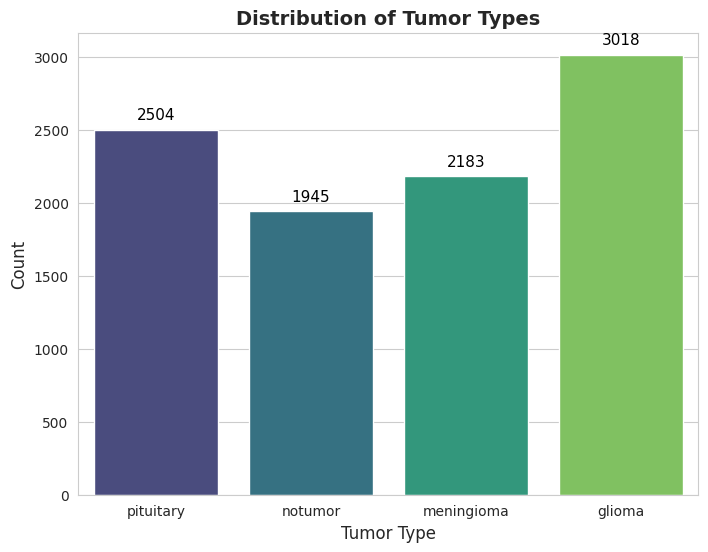

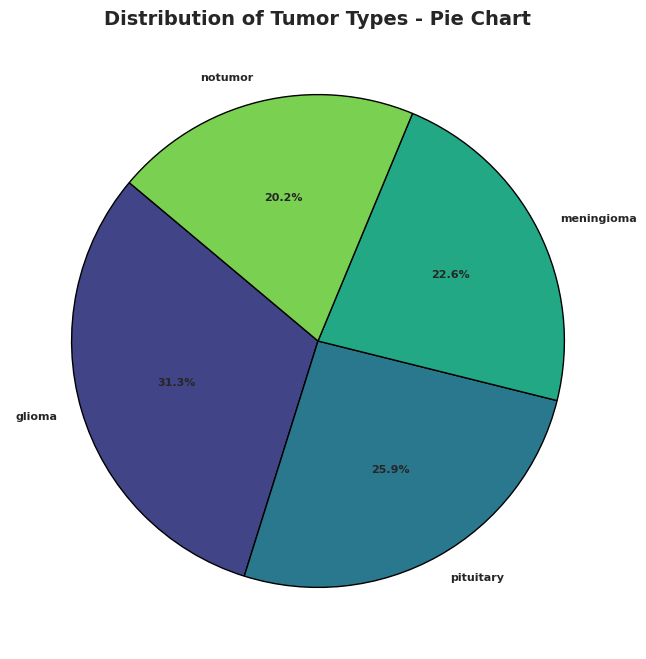

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
       startangle=140, colors=colors, textprops={'fontsize': 8, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

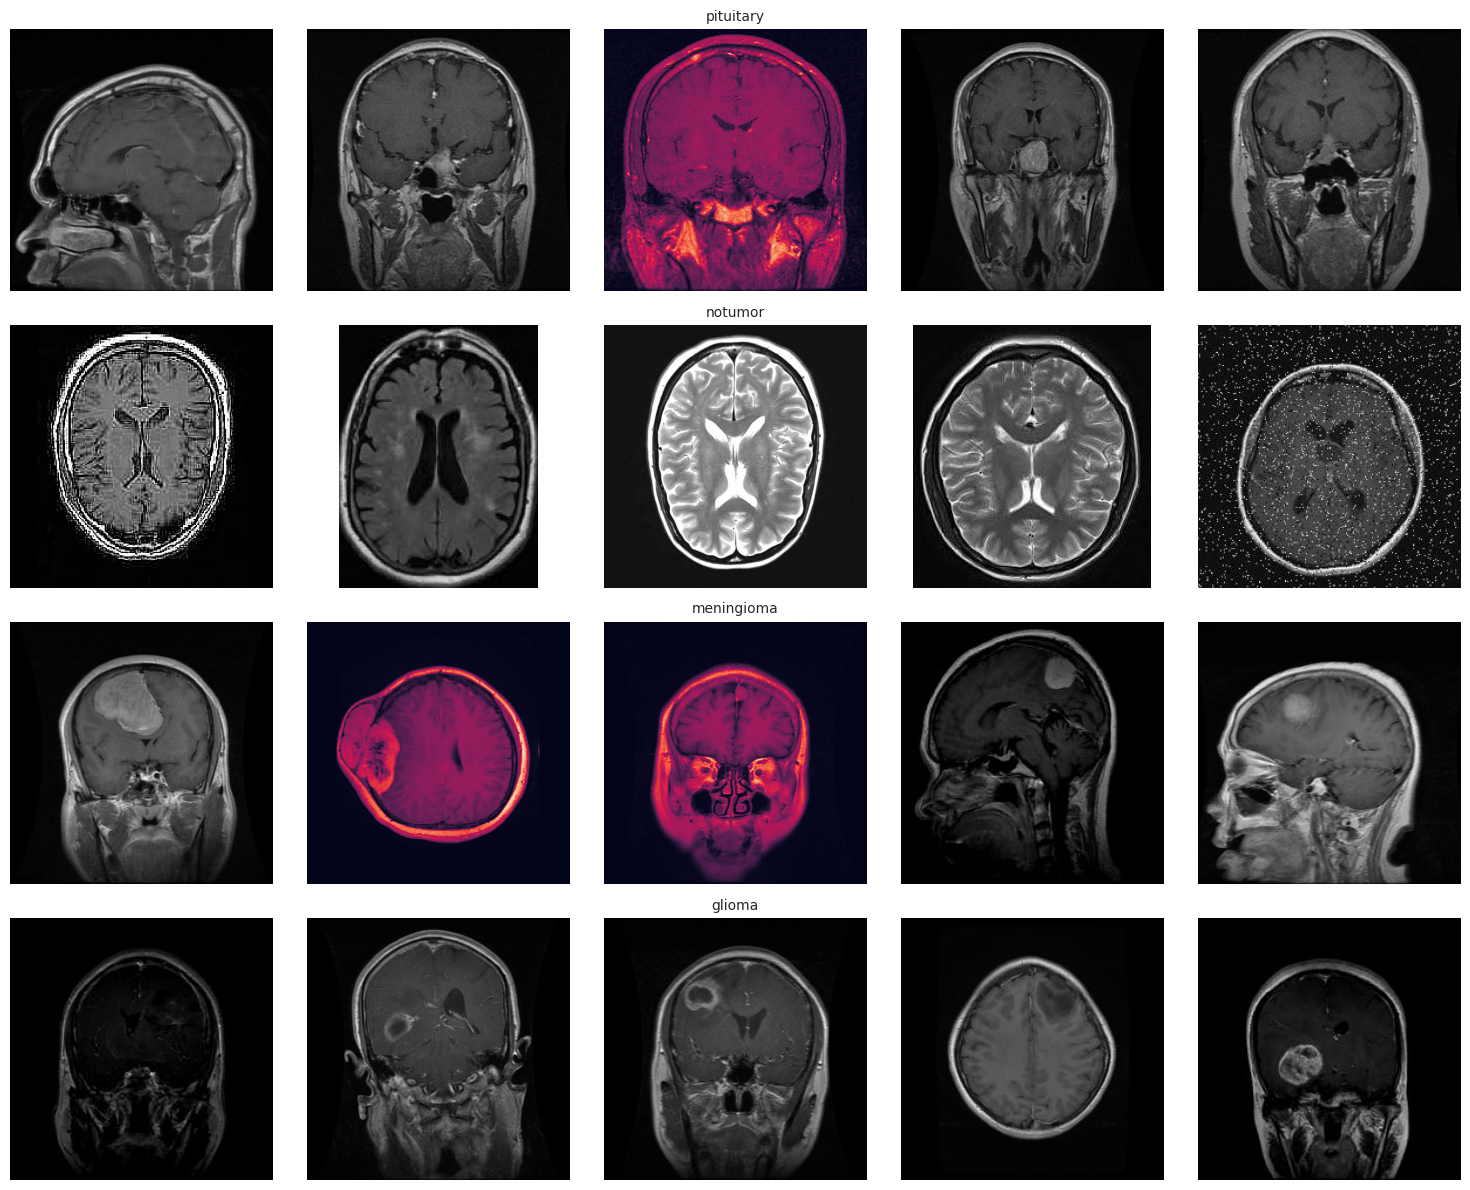

In [17]:
from PIL import Image

num_images = 5

unique_labels = df['label'].unique()

plt.figure(figsize=(15, len(unique_labels) * 3))

for row_idx, label in enumerate(unique_labels):
  
    label_images = df[df['label'] == label].head(num_images)['image_path'].tolist()
    
    for col_idx, img_path in enumerate(label_images):
        plt_idx = row_idx * num_images + col_idx + 1
        plt.subplot(len(unique_labels), num_images, plt_idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        if col_idx == 2:  
            plt.title(label, fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
max_samples = df['label'].value_counts().max()

balanced_df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max_samples, replace=True, random_state=42)
).reset_index(drop=True)

balanced_df = balanced_df[['image_path', 'label']]

In [19]:
df = balanced_df

In [20]:
df.head()

,image_path,label
0,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
1,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
2,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
3,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma
4,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma


In [21]:
df['label'].unique().tolist()

['glioma', 'meningioma', 'notumor', 'pituitary']

In [22]:
import pandas as pd
import os
import warnings

# ====================================================================
# 1. Dataset Collection Function (Unchanged)
# ====================================================================

def collect_dataset(root, splits=("train", "test")):
    """
    Collects file paths and labels from a structured directory.
    Assumes structure: root / split / label / image.
    Handles case-insensitive split names (e.g., 'train' vs 'Train' vs 'Training').
    """
    records = []
    if not os.path.exists(root):
        warnings.warn(f"Root path not found: {root}. Skipping this dataset.")
        return pd.DataFrame(records)

    for split in splits:
        # Check for original case (e.g., 'train')
        split_path = os.path.join(root, split)
        
        # Check for capitalized case (e.g., 'Train')
        if not os.path.exists(split_path):
            alt_split_path_cap = os.path.join(root, split.capitalize())
            if os.path.exists(alt_split_path_cap):
                split_path = alt_split_path_cap
            # Check for 'Training' case (if split is 'train')
            elif split.lower() == 'train':
                 alt_split_path_full = os.path.join(root, 'Training')
                 if os.path.exists(alt_split_path_full):
                      split_path = alt_split_path_full
                 else:
                      continue # Skip if neither case exists
            else:
                 continue # Skip if no matching split folder is found

        # Iterate through label folders
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for fname in os.listdir(label_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        records.append({
                            "image_path": os.path.join(label_path, fname),
                            "label": label,
                            # Ensure consistent split name: 'train' or 'test'
                            # 'Training' will become 'train' here due to .lower()
                            "split": split.lower()
                        })
    return pd.DataFrame(records)


# ====================================================================
# 2. Define Root Paths and Load Data (Expanded)
# ====================================================================

# --- Original Datasets ---
cscr_root = r"/kaggle/input/mri-clseg-dataset/CSCR hospital Dataset/Epic and CSCR hospital Dataset"


# --- Load Dataframes ---
df_cscr = collect_dataset(cscr_root, splits=("train", "test"))



In [23]:
print("Total images:", len(df_cscr))
print(df_cscr["split"].value_counts())
print(df_cscr["label"].value_counts().head())

Total images: 12064
split
train    9650
test     2414
Name: count, dtype: int64
label
glioma        3773
pituitary     3130
meningioma    2729
notumor       2432
Name: count, dtype: int64


In [24]:
print(df_cscr.head())

                                          image_path      label  split
0  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
1  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
2  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
3  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
4  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train


In [25]:
df_cscr["label"].unique()

array(['pituitary', 'notumor', 'meningioma', 'glioma'], dtype=object)

In [26]:
#  mapping labels
label_mapping = {
    'glioma_tumor': 'glioma',
    'meningioma_tumor': 'meningioma',
    'no_tumor': 'notumor',
    'pituitary_tumor': 'pituitary'
}

# Apply the mapping to the 'label' column in df4
df_cscr['label'] = df_cscr['label'].replace(label_mapping)
print(df_cscr.head())
print(df_cscr['label'].unique().tolist())

                                          image_path      label  split
0  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
1  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
2  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
3  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
4  /kaggle/input/mri-clseg-dataset/CSCR hospital ...  pituitary  train
['pituitary', 'notumor', 'meningioma', 'glioma']


In [27]:
print(df_cscr.shape)

(12064, 3)


In [28]:
# ====================================================================
# 3. Split Data
# ====================================================================
## --- Separate the combined data based on the 'split' column ---
train_df = df_cscr[df_cscr["split"] == "train"].copy()
test_df = df_cscr[df_cscr["split"] == "test"].copy()


# ====================================================================
# 4. Display Results
# ====================================================================

print("--- Final Combined Dataset Summary 📊 ---")
print(f"Total Combined Samples: **{len(df_cscr)}** images")
print(f"Unique Classes: **{sorted(df_cscr['label'].unique())}**")
print("-" * 34)
print(f"**Training Samples (split=='train'):** {len(train_df)} images")
print(f"**Testing Samples (split=='test'):** {len(test_df)} images")
print("-" * 34)

print("\n**Training Class Distribution:**")
print(train_df["label"].value_counts())

print("\n**Testing Class Distribution:**")
print(test_df["label"].value_counts())

--- Final Combined Dataset Summary 📊 ---
Total Combined Samples: **12064** images
Unique Classes: **['glioma', 'meningioma', 'notumor', 'pituitary']**
----------------------------------
**Training Samples (split=='train'):** 9650 images
**Testing Samples (split=='test'):** 2414 images
----------------------------------

**Training Class Distribution:**
label
glioma        3018
pituitary     2504
meningioma    2183
notumor       1945
Name: count, dtype: int64

**Testing Class Distribution:**
label
glioma        755
pituitary     626
meningioma    546
notumor       487
Name: count, dtype: int64


In [29]:
print(train_df.shape)
print(test_df.shape)

(9650, 3)
(2414, 3)


In [30]:
train_df.columns

Index(['image_path', 'label', 'split'], dtype='object')

In [31]:
train_df.duplicated().sum()

0

In [32]:
test_df.duplicated().sum()

0

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9650 entries, 0 to 9649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  9650 non-null   object
 1   label       9650 non-null   object
 2   split       9650 non-null   object
dtypes: object(3)
memory usage: 301.6+ KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2414 entries, 9650 to 12063
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2414 non-null   object
 1   label       2414 non-null   object
 2   split       2414 non-null   object
dtypes: object(3)
memory usage: 75.4+ KB


# Models

In [35]:
train_df

,image_path,label,split
0,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,train
1,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,train
2,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,train
3,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,train
4,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,train
...,...,...,...
9645,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,train
9646,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,train
9647,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,train
9648,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,train


In [36]:
test_df

,image_path,label,split
9650,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,test
9651,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,test
9652,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,test
9653,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,test
9654,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,pituitary,test
...,...,...,...
12059,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,test
12060,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,test
12061,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,test
12062,/kaggle/input/mri-clseg-dataset/CSCR hospital ...,glioma,test


# RESNET152 - Encoder  : MTA-Net -- Classification Model  

Data successfully referenced. Total Training Samples: 9650
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 231MB/s]


Model initialized: MTA_Net_ResNet152 (using ResNet152 encoder).
Total trainable parameters: 62,871,109

--- Starting Multi-Task Training on cuda ---
Initial LR: 0.000100 | ES Patience: 5 | LR Patience: 3
Validation loss decreased (inf --> 0.137678). Saving model...
Epoch 1/50 | Loss: 0.3168 | Val Loss: 0.1377 | Train Acc/AUC: 0.9187/0.9893 | Val Acc/AUC: 0.9573/0.9974 | LR: 0.000100
EarlyStopping counter: 1 out of 5.
Epoch 2/50 | Loss: 0.0559 | Val Loss: 0.1448 | Train Acc/AUC: 0.9886/0.9996 | Val Acc/AUC: 0.9606/0.9966 | LR: 0.000100
Validation loss decreased (0.137678 --> 0.130849). Saving model...
Epoch 3/50 | Loss: 0.0425 | Val Loss: 0.1308 | Train Acc/AUC: 0.9917/0.9996 | Val Acc/AUC: 0.9627/0.9980 | LR: 0.000100
Validation loss decreased (0.130849 --> 0.099327). Saving model...
Epoch 4/50 | Loss: 0.0407 | Val Loss: 0.0993 | Train Acc/AUC: 0.9915/0.9996 | Val Acc/AUC: 0.9760/0.9980 | LR: 0.000100
EarlyStopping counter: 1 out of 5.
Epoch 5/50 | Loss: 0.0252 | Val Loss: 0.1003 | Tra

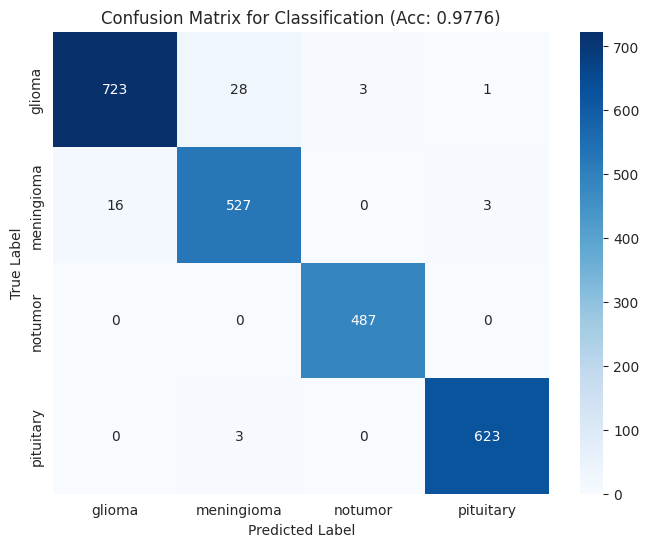


--- Generating AUC-ROC Curve (Validation Set) ---
Macro-Average AUC: 0.9985


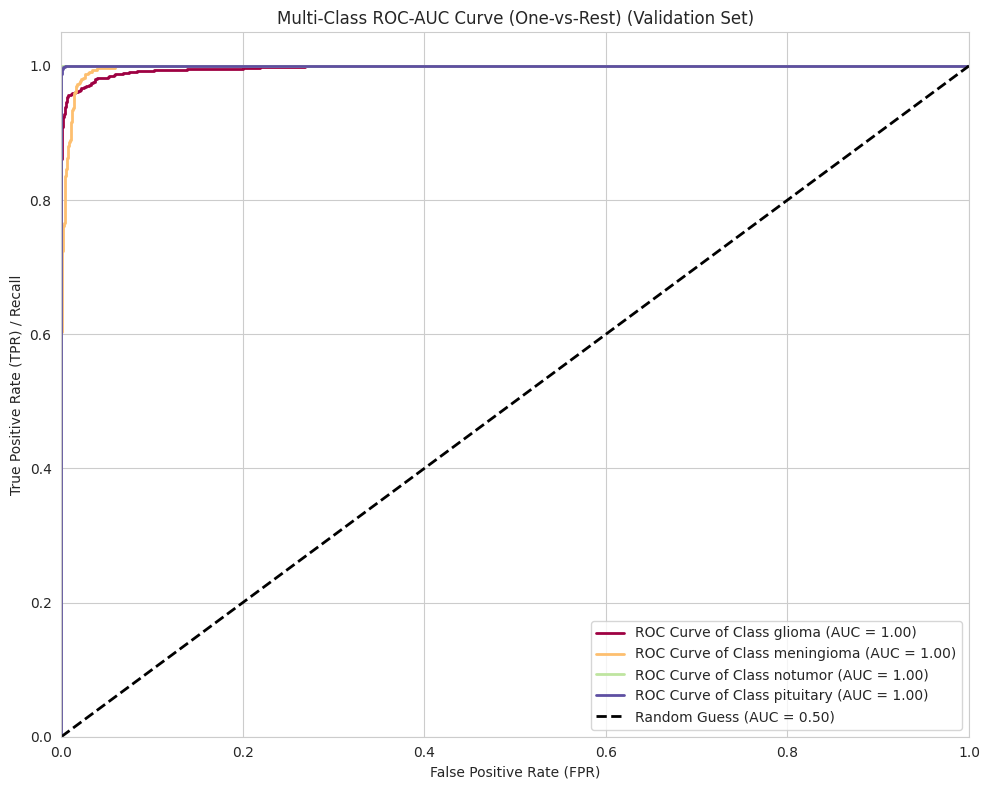


--- Final Training Classification Metrics ---
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      1.00      1.00      3018
  meningioma       1.00      1.00      1.00      2183
     notumor       1.00      1.00      1.00      1945
   pituitary       1.00      1.00      1.00      2504

    accuracy                           1.00      9650
   macro avg       1.00      1.00      1.00      9650
weighted avg       1.00      1.00      1.00      9650

Overall Training Accuracy: 0.9996
Final Training Macro-AUC: 0.9998

--- Generating AUC-ROC Curve (Training Set) ---
Macro-Average AUC: 0.9998


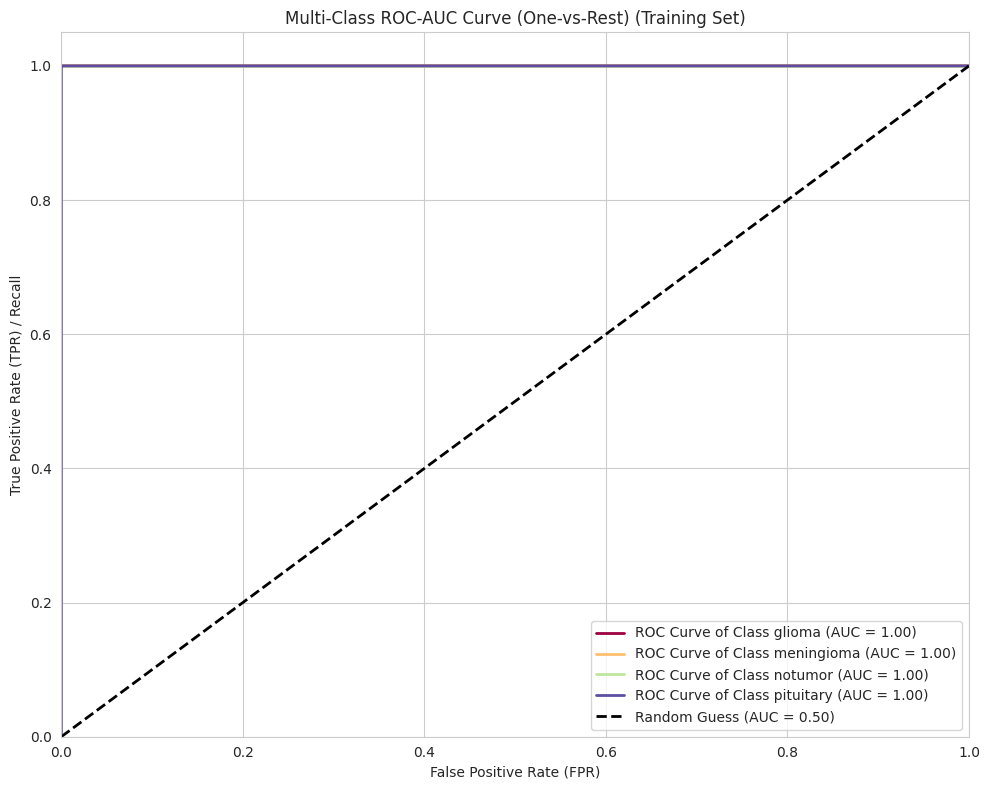


Final Model Macro-AUC Scores:
  Training AUC: 0.9998
  Validation AUC: 0.9985


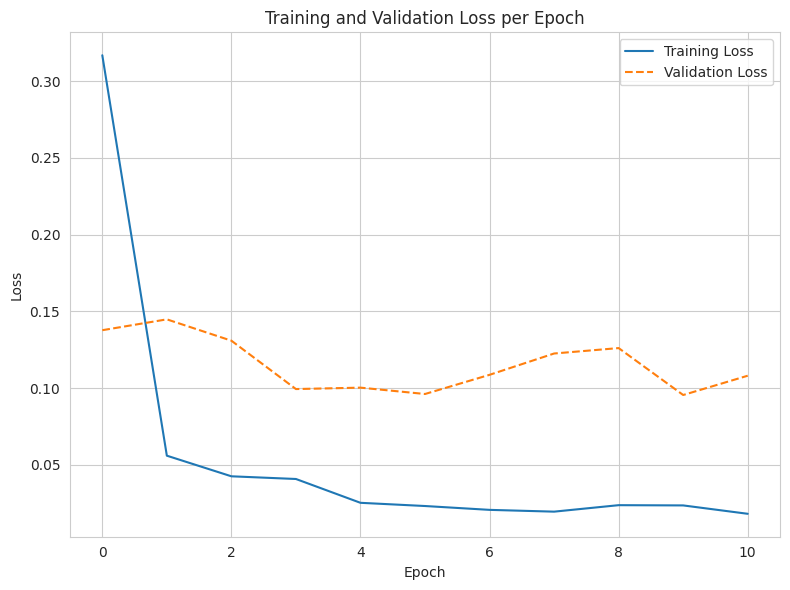

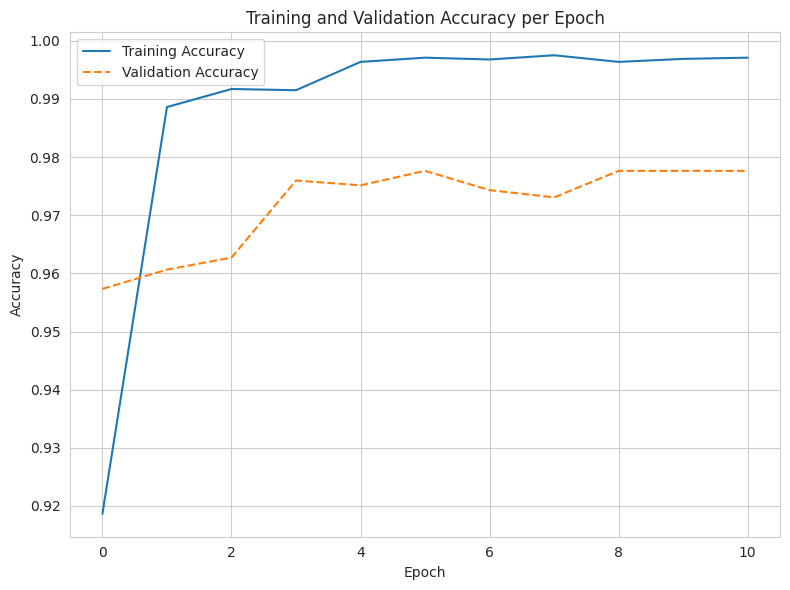

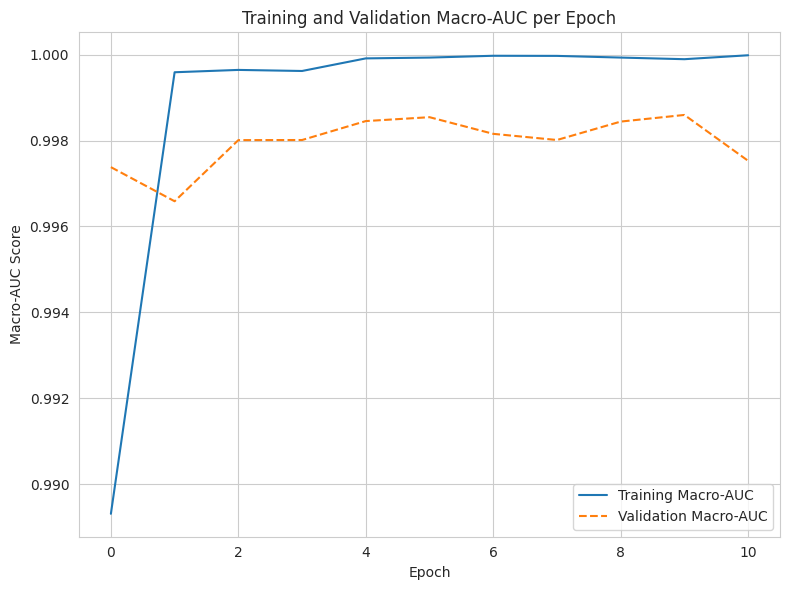

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import copy
from collections import defaultdict 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# ==============================================================================
# --- 1. CONFIGURATION AND DATA LOADING ASSUMPTION ---
# ==============================================================================

# Placeholder variables for execution:
try:
    # Attempt to use existing dataframes if they are defined
    CLASS_LABELS = sorted(train_df['label'].unique().tolist())
except NameError:
    # Dummy DataFrames for a runnable snippet structure (Restored 128/64)
    CLASS_LABELS = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
    n_samples_train = 128 # Must be at least BATCH_SIZE
    n_samples_test = 64
    train_data = pd.DataFrame({
        'image_path': [f'img_train_{i}.png' for i in range(n_samples_train)], 
        'label': np.random.choice(CLASS_LABELS, size=n_samples_train)
    })
    test_data = pd.DataFrame({
        'image_path': [f'img_test_{i}.png' for i in range(n_samples_test)], 
        'label': np.random.choice(CLASS_LABELS, size=n_samples_test)
    })
    train_df = train_data
    test_df = test_data


NUM_CLASSES = len(CLASS_LABELS)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_LABELS)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

IMG_SIZE = 224
NUM_SEG_CLASSES = 1 # Binary segmentation (Tumor vs. Background)
BATCH_SIZE = 32

print(f"Data successfully referenced. Total Training Samples: {len(train_df)}")
print(f"Classes: {CLASS_LABELS}")

# --- Multi-Task Dataset Class ---
class MultiTaskDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.class_to_idx = CLASS_TO_IDX

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label_name = row['label']

        try:
            # Attempt to open file (will fail with dummy paths)
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            # Fallback for missing files: use a placeholder black image
            image = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        cls_y = self.class_to_idx[label_name]

        # Simulated Segmentation Mask (Dummy Task for MTL)
        seg_y = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
        if label_name != 'no_tumor':
            s = IMG_SIZE // 4
            e = IMG_SIZE * 3 // 4
            seg_y[0, s:e, s:e] = 1.0

        return image, seg_y, torch.tensor(cls_y, dtype=torch.long)

# --- Transforms and DataLoaders ---
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MultiTaskDataset(train_df, transform=data_transforms)
test_dataset = MultiTaskDataset(test_df, transform=data_transforms)
# Set num_workers=0 for better compatibility in snippets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# ==============================================================================
# --- 2. MTA-NET MODEL DEFINITION (MODIFIED FOR RESNET152) ---
# ==============================================================================
class MTA_Net_ResNet152(nn.Module):
    def __init__(self, num_classes, num_seg_classes):
        super().__init__()
        # Use ResNet152 backbone (closest standard model to ResNet151)
        weights = models.ResNet152_Weights.IMAGENET1K_V2
        backbone = models.resnet152(weights=weights)

        # Extract features up to layer4
        self.common_feature_extractor = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool,
            backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4
        )
        # ResNet152 final feature dimension
        self.common_features_dim = 2048 
        
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Classification Head
        self.cls_head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.common_features_dim, num_classes)
        )
        
        # Segmentation Head
        self.seg_head = nn.Sequential(
            nn.Conv2d(self.common_features_dim, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_seg_classes, kernel_size=1),
        )

    def forward(self, x):
        features = self.common_feature_extractor(x)
        cls_features = self.pooling(features)
        cls_features = torch.flatten(cls_features, 1)
        cls_output = self.cls_head(cls_features)

        seg_output = self.seg_head(features)
        # Upsample segmentation output to match input size
        seg_output = F.interpolate(seg_output, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

        return seg_output, cls_output


# ==============================================================================
# --- 3. TRAINING HELPERS (Early Stopping and Metrics) ---
# ==============================================================================

class EarlyStopper:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, min_delta=0, verbose=False, checkpoint_path='best_mtl_checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.checkpoint_path = checkpoint_path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
            self.best_loss = val_loss
            self.val_loss_min = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}.')
            if self.counter >= self.patience:
                self.early_stop = True

# AUC Calculation Function
def calculate_macro_auc(y_true, y_probas, n_classes):
    """Calculates macro-averaged AUC across all classes."""
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    roc_auc = []
    
    if y_true_bin.shape[0] == 0:
        return 0.0

    for i in range(n_classes):
        # Handle classes with no positive/negative samples
        if np.sum(y_true_bin[:, i]) == 0 or np.sum(y_true_bin[:, i]) == y_true_bin.shape[0]:
            roc_auc.append(0.5) 
            continue
            
        try:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probas[:, i])
            roc_auc.append(auc(fpr, tpr))
        except ValueError:
            roc_auc.append(0.5)

    return np.mean(roc_auc)


# Now returns loss, accuracy, and AUC
def train_one_epoch(model, train_loader, optimizer, device, lambda_cls=1.0):
    model.train()
    total_loss = 0; all_cls_trues = []; all_cls_probas = []

    for x, seg_y, cls_y in train_loader:
        x, seg_y, cls_y = x.to(device), seg_y.to(device), cls_y.to(device)
        optimizer.zero_grad()
        seg_outputs, cls_outputs = model(x)
        seg_loss = F.binary_cross_entropy_with_logits(seg_outputs, seg_y)
        cls_loss = F.cross_entropy(cls_outputs, cls_y)
        loss = (lambda_cls * cls_loss) + seg_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Gather metrics for accuracy and AUC
        probas = F.softmax(cls_outputs, dim=1)
        all_cls_trues.extend(cls_y.cpu().numpy())
        all_cls_probas.extend(probas.detach().cpu().numpy())

    y_true = np.array(all_cls_trues)
    y_probas = np.array(all_cls_probas)
    train_accuracy = accuracy_score(y_true, y_probas.argmax(axis=1))
    train_auc = calculate_macro_auc(y_true, y_probas, len(CLASS_LABELS))
    
    return total_loss / len(train_loader), train_accuracy, train_auc

# Now returns loss, accuracy, and AUC
def get_validation_metrics(model, loader, device, lambda_cls=1.0):
    model.eval()
    total_val_loss = 0; all_cls_trues = []; all_cls_probas = []

    with torch.no_grad():
        for x, seg_y, cls_y in loader:
            x, seg_y, cls_y = x.to(device), seg_y.to(device), cls_y.to(device)
            seg_outputs, cls_outputs = model(x)
            seg_loss = F.binary_cross_entropy_with_logits(seg_outputs, seg_y)
            cls_loss = F.cross_entropy(cls_outputs, cls_y)
            loss = (lambda_cls * cls_loss) + seg_loss
            total_val_loss += loss.item()

            # Gather metrics for accuracy and AUC
            probas = F.softmax(cls_outputs, dim=1)
            all_cls_trues.extend(cls_y.cpu().numpy())
            all_cls_probas.extend(probas.cpu().numpy())

    y_true = np.array(all_cls_trues)
    y_probas = np.array(all_cls_probas)
    val_accuracy = accuracy_score(y_true, y_probas.argmax(axis=1))
    avg_val_loss = total_val_loss / len(loader)
    val_auc = calculate_macro_auc(y_true, y_probas, len(CLASS_LABELS))
    
    return avg_val_loss, val_accuracy, val_auc

# --- Metric Plotting Functions (Updated for Macro-AUC Plot) ---
def plot_multiclass_roc_auc(y_true, y_probas, class_labels, title_suffix=""):
    print(f"\n--- Generating AUC-ROC Curve {title_suffix} ---")
    n_classes = len(class_labels)
    
    if len(np.unique(y_true)) < 2:
        print(f"Skipping ROC-AUC plot {title_suffix}: Not enough class variation in data.")
        return
        
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    macro_auc_scores = []

    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('Spectral', n_classes)
    
    for i in range(n_classes):
        if np.sum(y_true_bin[:, i]) == 0 or np.sum(y_true_bin[:, i]) == y_true_bin.shape[0]:
            continue

        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        macro_auc_scores.append(roc_auc[i])
        
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                     label=f'ROC Curve of Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    if macro_auc_scores:
        macro_auc_mean = np.mean(macro_auc_scores)
        print(f"Macro-Average AUC: {macro_auc_mean:.4f}")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.50)')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR) / Recall')
    plt.title(f'Multi-Class ROC-AUC Curve (One-vs-Rest) {title_suffix}'); plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout(); plt.show()
    

def plot_loss_metrics(history):
    """Plots Training Loss vs. Validation Loss over epochs."""
    epochs = range(len(history['train_loss']))
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
    

def plot_accuracy_metrics(history):
    """Plots Training Accuracy vs. Validation Accuracy over epochs."""
    epochs = range(len(history['train_accuracy']))
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    

# Function to plot AUC history
def plot_auc_metrics(history):
    """Plots Training Macro-AUC vs. Validation Macro-AUC over epochs."""
    epochs = range(len(history['train_auc']))
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['train_auc'], label='Training Macro-AUC')
    plt.plot(epochs, history['val_auc'], label='Validation Macro-AUC', linestyle='--')
    plt.title('Training and Validation Macro-AUC per Epoch')
    plt.xlabel('Epoch'); plt.ylabel('Macro-AUC Score'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()
    

def validate_and_show_metrics(model, loader, num_classes, device, print_report=True, dataset_name="Validation"):
    model.eval()
    all_cls_trues = []; all_cls_probas = []

    with torch.no_grad():
        for x, _, cls_y in loader:
            x, cls_y = x.to(device), cls_y.to(device)
            _, cls_outputs = model(x)
            
            probas = F.softmax(cls_outputs, dim=1)
            
            all_cls_trues.extend(cls_y.cpu().numpy())
            all_cls_probas.extend(probas.cpu().numpy())

    y_true = np.array(all_cls_trues); y_probas = np.array(all_cls_probas)
    y_pred = y_probas.argmax(axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    final_auc = calculate_macro_auc(y_true, y_probas, num_classes)

    if print_report:
        print(f"\n--- Final {dataset_name} Classification Metrics ---")
        report = classification_report(y_true, y_pred, target_names=CLASS_LABELS, zero_division=0)
        print("Classification Report:\n", report)
        print(f"Overall {dataset_name} Accuracy: {accuracy:.4f}")
        print(f"Final {dataset_name} Macro-AUC: {final_auc:.4f}")

        if dataset_name == "Validation":
            cm = confusion_matrix(y_true, y_pred)
            labels = [IDX_TO_CLASS[i] for i in range(num_classes)]
            title = f'Confusion Matrix for Classification (Acc: {accuracy:.4f})'
            plot_confusion_matrix(cm, title, labels)
        
        plot_multiclass_roc_auc(y_true, y_probas, CLASS_LABELS, title_suffix=f"({dataset_name} Set)")
        
    return accuracy, final_auc

# ==============================================================================
# --- 4. MAIN TRAINING FUNCTION (With Early Stopping and LR Schedule) ---
# ==============================================================================
def train_model_mtl(model,
                    train_loader,
                    val_loader,
                    num_classes,
                    device='cuda',
                    epochs=50, 
                    lr=1e-4,
                    patience=5,
                    lr_patience=3,
                    min_delta=1e-3
                    ):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=lr_patience,
        min_lr=1e-6
    )

    early_stopper = EarlyStopper(
        patience=patience,
        min_delta=min_delta,
        verbose=True,
        checkpoint_path='best_mtl_checkpoint.pt'
    )

    # Added AUC tracking keys
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_auc': [], 'val_auc': [], 
        'learning_rate': []
    }

    print(f"\n--- Starting Multi-Task Training on {device} ---")
    print(f"Initial LR: {lr:.6f} | ES Patience: {patience} | LR Patience: {lr_patience}")

    for epoch in range(1, epochs + 1):
        # 1. Training Phase (Returns AUC)
        train_loss, train_accuracy, train_auc = train_one_epoch(model, train_loader, optimizer, device)

        # 2. Validation Phase (Returns AUC)
        val_loss, val_accuracy, val_auc = get_validation_metrics(model, val_loader, device)

        # 3. Learning Rate Scheduling Step
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # 4. Early Stopping Check
        early_stopper(val_loss, model)

        # 5. Record History
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['train_auc'].append(train_auc) 
        history['val_auc'].append(val_auc)     
        history['learning_rate'].append(current_lr)

        print(f"Epoch {epoch}/{epochs} | Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc/AUC: {train_accuracy:.4f}/{train_auc:.4f} | Val Acc/AUC: {val_accuracy:.4f}/{val_auc:.4f} | LR: {current_lr:.6f}")

        # 6. Stop Training
        if early_stopper.early_stop:
            print(f"🔥 Early stopping triggered after {epoch} epochs. Loading best model weights...")
            model.load_state_dict(torch.load(early_stopper.checkpoint_path))
            break

    # Final evaluation using the best model weights
    print(f"\n--- Final Evaluation ---")
    
    # Load best checkpoint if early stopping occurred, otherwise use last epoch model
    if os.path.exists(early_stopper.checkpoint_path):
         model.load_state_dict(torch.load(early_stopper.checkpoint_path))
    
    # Plot final ROC AUC for Validation Set and generate Confusion Matrix
    val_acc, val_auc_final = validate_and_show_metrics(model, val_loader, num_classes, device, print_report=True, dataset_name="Validation")
    
    # Plot final ROC AUC for Training Set
    train_acc, train_auc_final = validate_and_show_metrics(model, train_loader, num_classes, device, print_report=True, dataset_name="Training")
    
    # Print final AUC scores
    print("\nFinal Model Macro-AUC Scores:")
    print(f"  Training AUC: {train_auc_final:.4f}")
    print(f"  Validation AUC: {val_auc_final:.4f}")

    # Plot metrics (The requested plots are here)
    plot_loss_metrics(history)
    plot_accuracy_metrics(history) 
    plot_auc_metrics(history) 

    return history

# ==============================================================================
# --- 5. FINAL EXECUTION BLOCK ---
# ==============================================================================
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Use the ResNet152 model class
    model = MTA_Net_ResNet152(num_classes=NUM_CLASSES, num_seg_classes=NUM_SEG_CLASSES)
    print("Model initialized: MTA_Net_ResNet152 (using ResNet152 encoder).")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    train_model_mtl(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_classes=NUM_CLASSES,
        device=device,
        epochs=50, # Reduced epochs for snippet demonstration
        lr=1e-4,
        patience=5,
        lr_patience=3,
        min_delta=1e-3
    )

# Prediction

In [38]:
# Assuming you want the row with the integer position 10 (which is the 11th row)
print("--- Data for Row Position 10 (11th Row) in test_df ---")
row_10_info = test_df.iloc[10]
print(row_10_info)

--- Data for Row Position 10 (11th Row) in test_df ---
image_path    /kaggle/input/mri-clseg-dataset/CSCR hospital ...
label                                                 pituitary
split                                                      test
Name: 9660, dtype: object


In [39]:
# ==============================================================================
# --- 6. INFERENCE AND MODEL LOADING FUNCTIONS ---

# --- Helper function definitions (must be outside the final execution block) ---
def load_best_model(model_class, num_classes, num_seg_classes, checkpoint_path, device):
    """Loads the best model state dictionary from a checkpoint file."""
    model = model_class(num_classes, num_seg_classes)
    model.to(device)
    
    # Check if the file exists from training
    if not os.path.exists(checkpoint_path):
        print(f"⚠️ Warning: Checkpoint file '{checkpoint_path}' not found.")
        print("Using the model in its current, potentially untrained state.")
        return model

    # Load the state dictionary
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval() # Set model to evaluation mode
    print(f"✅ Successfully loaded model weights from {checkpoint_path}")
    return model

def predict_single_sample(model, dataset, sample_index, device):
    """
    Retrieves a single sample from the dataset and makes a prediction.
    """
    # 1. Get the sample from the dataset (image, seg_y, cls_y)
    # The image path is in the original test_df at this index.
    image, _, cls_y_true_idx = dataset[sample_index]
    
    # 2. Add batch dimension and move to device
    input_image = image.unsqueeze(0).to(device)
    
    # 3. Run inference
    with torch.no_grad():
        seg_output, cls_output = model(input_image)

    # 4. Process Classification Output
    probas = F.softmax(cls_output, dim=1).cpu().numpy().flatten()
    predicted_idx = np.argmax(probas)

    # 5. Map indices back to class names
    true_label = IDX_TO_CLASS[cls_y_true_idx.item()]
    predicted_label = IDX_TO_CLASS[predicted_idx]
    
    # 6. Process Segmentation Output
    seg_mask = torch.sigmoid(seg_output).squeeze().cpu().numpy()
    
    return true_label, predicted_label, probas, seg_mask

# ==============================================================================
# --- INFERENCE EXECUTION BLOCK (Run AFTER your training) ---

# We only run this block if the main training script was executed.
if __name__ == '__main__':
    
    # ----------------------------------------------------
    # Ensure the model is loaded from the best checkpoint
    # ----------------------------------------------------
    
    # The device variable should still be set from the training block
    if 'device' not in locals():
         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
         
    # Load the best weights into a new model instance
    best_model = load_best_model(
        model_class=MTA_Net_ResNet152, 
        num_classes=NUM_CLASSES, 
        num_seg_classes=NUM_SEG_CLASSES, 
        checkpoint_path='best_mtl_checkpoint.pt', 
        device=device
    )

    # ----------------------------------------------------
    # Predict on the requested Row 10 (positional index 10)
    # ----------------------------------------------------
    sample_index_to_predict = 10 
    
    # --- Extract Row Info for Display ---
    if sample_index_to_predict >= len(test_df):
        print(f"Index {sample_index_to_predict} is out of bounds for test_df (size {len(test_df)}). Using index 0 instead.")
        sample_index_to_predict = 0
        
    df_row_info = test_df.iloc[sample_index_to_predict]
    print(f"\n--- Prediction Sample Details (Row {sample_index_to_predict}) ---")
    print(df_row_info)
    print("\n--- Running Single Prediction ---")

    # --- Run the Prediction ---
    true_label, predicted_label, probas, seg_mask = predict_single_sample(
        best_model, 
        test_dataset, 
        sample_index_to_predict, 
        device
    )

    # --- Display Results ---
    print("\n--- Prediction Results ---")
    print(f"True Class: **{true_label}**")
    print(f"Predicted Class: **{predicted_label}**")
    print("\nClassification Probabilities:")
    for i, cls in enumerate(CLASS_LABELS):
        print(f"  {cls}: {probas[i]:.4f}")
    

    

✅ Successfully loaded model weights from best_mtl_checkpoint.pt

--- Prediction Sample Details (Row 10) ---
image_path    /kaggle/input/mri-clseg-dataset/CSCR hospital ...
label                                                 pituitary
split                                                      test
Name: 9660, dtype: object

--- Running Single Prediction ---

--- Prediction Results ---
True Class: **pituitary**
Predicted Class: **pituitary**

Classification Probabilities:
  glioma: 0.0000
  meningioma: 0.0000
  notumor: 0.0000
  pituitary: 1.0000
